In [1]:
import json
import numpy as np  # 1.23.5
import pandas as pd  # 1.5.0
import matplotlib.pyplot as plt  # 3.6.2
import seaborn as sns  # 0.12.0

from tqdm.auto import tqdm
from zipfile import ZipFile
from valence_angle import ValenceAngle

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # 1.2.2

# 1) Load and prepare the data

In [2]:
# Load data.

df = pd.read_csv(r"F:\FIA_GENERATION\for_publication\FINAL\FIA49k.csv.gz")
df.shape

(48986, 57)

In [3]:
# Limit the data set to high-valent group 14 atom-based data points.

df = df[df["ca_group"] == 14]
df = df[df["Compound"].str.contains("_4_")]
df.shape

(10204, 57)

In [4]:
# Load relevant xyz structures.

relevant_xyz_data = {}

with ZipFile(r"F:\FIA_GENERATION\for_publication\FINAL\FIA49k.zip", "r") as zip_ref:
    for file_name in zip_ref.namelist():
        if file_name.endswith(".json"):
            with zip_ref.open(file_name) as f:
                xyz_data = json.loads(f.read().decode("utf-8"))
                
                for name, data in xyz_data.items():
                    if name in list(df.Compound):
                        relevant_xyz_data[name] = data["fa-PBEh3c"].split("\n")

len(relevant_xyz_data)

10204

# 2) Get the largest F-central_atom-X angle

In [5]:
# Get the angle and classify the data either as "apical" or "equatorial".

angles = []
angle_classification = []

for compound, xyz_coords in tqdm(relevant_xyz_data.items()):
    angle_analysis = ValenceAngle(xyz_coords)
    angle_analysis.get_element_F_angles()
    angles.append(angle_analysis.max_fluoride_valence_angle)
    
    if angle_analysis.max_fluoride_valence_angle > 150:
        angle_classification.append("ap")
    else:
        angle_classification.append("eq")

len(angles), len(angle_classification)

  0%|          | 0/10204 [00:00<?, ?it/s]

(10204, 10204)

In [6]:
# Add data to df.

df["max_fluoride_valence_angle"] = angles
df["angle_class_label"] = angle_classification
df.shape

(10204, 59)

# 3) Make plots

In [7]:
# Make the plots only for the FIA44k data set.

df_fia44k = df[df["mol_type"] == "fia44k"]
df_fia44k.shape

(9138, 59)

C:\Users\lukas\AppData\Local\Temp\ipykernel_17748\1766683382.py:3: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.histplot(
C:\Users\lukas\Anaconda3\envs\ml_env_local\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


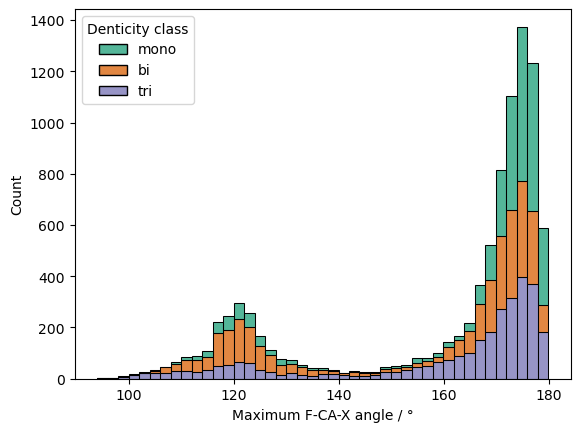

In [8]:
# Plot 1.

ax = sns.histplot(
    data=df_fia44k, 
    x="max_fluoride_valence_angle",
    binwidth=2,
    hue="denticity_class",
    hue_order=["mono", "bi", "tri"],
    multiple="stack",
    palette=sns.color_palette("Dark2")
)

plt.xlabel("Maximum F-CA-X angle / °")
ax.legend_.set_title("Denticity class")

C:\Users\lukas\AppData\Local\Temp\ipykernel_17748\995309854.py:3: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax = sns.histplot(
C:\Users\lukas\Anaconda3\envs\ml_env_local\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


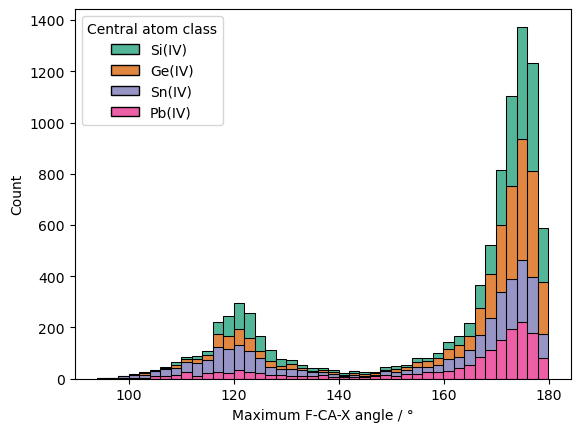

In [9]:
# Plot 2.

ax = sns.histplot(
    data=df_fia44k, 
    x="max_fluoride_valence_angle",
    binwidth=2,
    hue="ca_class",
    hue_order=["Si(IV)", "Ge(IV)", "Sn(IV)", "Pb(IV)"],
    multiple="stack",
    palette=sns.color_palette("Dark2")
)

plt.xlabel("Maximum F-CA-X angle / °")
ax.legend_.set_title("Central atom class")

# 4) Calculate class sizes and average FIA values

In [10]:
# Counts.
counts = dict(df_fia44k.groupby(["angle_class_label"])["fia_gas-DSDBLYP"].count())

# Average FIA_gas.
average_fia_gas = dict(df_fia44k.groupby(["angle_class_label"])["fia_gas-DSDBLYP"].mean())

# Average FIA_solv.
average_fia_solv = dict(df_fia44k.groupby(["angle_class_label"])["fia_solv-DSDBLYP"].mean())

In [11]:
print("------------")
print("Distribution")
print("------------")
print(f"apical:       {counts['ap'] / sum(counts.values())}")
print(f"equatorial:   {counts['eq'] / sum(counts.values())}")
print()
print("---------------")
print("Average FIA_gas")
print("---------------")
print(f"apical:       {average_fia_gas['ap']}")
print(f"equatorial:   {average_fia_gas['eq']}")
print()
print("----------------")
print("Average FIA_solv")
print("----------------")
print(f"apical:       {average_fia_solv['ap']}")
print(f"equatorial:   {average_fia_solv['eq']}")
print()
print("-----------")
print("Differences")
print("-----------")
print(f"FIA_gas:      {average_fia_gas['eq']-average_fia_gas['ap']}")
print(f"FIA_solv:     {average_fia_solv['eq']-average_fia_solv['ap']}")

------------
Distribution
------------
apical:       0.7535565769314948
equatorial:   0.24644342306850514

---------------
Average FIA_gas
---------------
apical:       289.9444381440076
equatorial:   327.3551426797189

----------------
Average FIA_solv
----------------
apical:       102.32407157415574
equatorial:   133.9753627507668

-----------
Differences
-----------
FIA_gas:      37.41070453571126
FIA_solv:     31.651291176611068


# 5) Train classifier

In [12]:
# Load FIA-GNN molecular representations.

fia_gnn_embeddings = pd.read_csv(r"F:\FIA_GENERATION\for_publication\FINAL\FIA49k_fia_gnn_embeddings.csv.gz")
fia_gnn_embeddings = fia_gnn_embeddings[fia_gnn_embeddings["Compound"].isin(df["Compound"])]
fia_gnn_embeddings.shape

(10204, 321)

In [13]:
# Formatting.

fia_gnn_embeddings = fia_gnn_embeddings.drop([col for col in fia_gnn_embeddings.columns if "vec32_gas_" not in col and "Compound" not in col], axis=1)
fia_gnn_embeddings = fia_gnn_embeddings.merge(df[["Compound", "set_assignment", "angle_class_label"]], on="Compound")
fia_gnn_embeddings.shape

(10204, 35)

In [14]:
# Get features and labels.

X_train = fia_gnn_embeddings.loc[fia_gnn_embeddings["set_assignment"] == "train"]
X_test = fia_gnn_embeddings.loc[fia_gnn_embeddings["set_assignment"] == "test"]

y_train = X_train["angle_class_label"]
y_test = X_test["angle_class_label"]

to_be_droped = [col for col in list(fia_gnn_embeddings.columns) if all([not col.startswith("vec32_gas_")])]

X_train = X_train.drop(to_be_droped, axis=1)
X_test = X_test.drop(to_be_droped, axis=1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6662, 32), (6662,), (1358, 32), (1358,))

In [15]:
# Train model (A LazyClassifier (https://lazypredict.readthedocs.io/en/latest/) was used to indentify LDA as the best model.).

classifier = LinearDiscriminantAnalysis()
classifier.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [16]:
# Make predictions for the test set.

predictions = classifier.predict(X_test)

In [17]:
# Analyze predictions.

correct = 0

for true, pred in zip(y_test, predictions):
    if true == pred:
        correct += 1

print(f"Accuracy: {correct/len(y_test)}")

Accuracy: 0.7864506627393225


In [18]:
# Make predictions for bis(catecholato)silanes and -germanes.

cat_df = fia_gnn_embeddings[fia_gnn_embeddings["Compound"].isin([
    "Si_4_DB000021", # (Cl_cat)2Si
    "Si_4_DB000042", # (F_cat)2Si
    "Ge_4_DB000022", # (Cl_cat)2Ge
    "Ge_4_DB000043", # (F_cat)2Ge
])]

cat_df = cat_df.drop(to_be_droped, axis=1)
cat_df.shape

(4, 32)

In [19]:
# Predict.

classifier.predict(cat_df)

array(['eq', 'eq', 'eq', 'eq'], dtype='<U2')

In [20]:
# Predict.

classifier.predict_proba(cat_df)

array([[0.13201557, 0.86798443],
       [0.21651483, 0.78348517],
       [0.08635714, 0.91364286],
       [0.32905506, 0.67094494]])